In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
#loading the csv data to a Pandas Dataframe
df = pd.read_csv('/content/sample_data/dataset1water (1).csv')

In [4]:
#printing first 5 rows of the dataframe
df.head()

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545,92.74583,2021,7.74,...,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.6025,92.73,2021,7.53,...,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,2021,7.50,...,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.7325,92.70861,2021,7.60,...,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,2021,7.82,...,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [5]:
# Checking size of the dataset
df.shape

(5375, 23)

In [6]:
# Checking for datatypes of the dataset
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE      object
LONGITUDE     object
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

# Converting object data type to numeric

In [7]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 6
    for index in range(6, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

In [8]:
df.isnull().sum()

Well ID         0
S.No            0
STATE           0
DISTRICT        0
BLOCK          71
LOCATION        0
LATITUDE      811
LONGITUDE     810
Year            0
pH              0
EC              0
CO3             0
HCO3            0
Cl              0
SO4             1
NO3             0
TH              0
Ca              0
Mg              0
Na              0
K               1
F               0
TDS          2159
dtype: int64

# Handling null values

In [9]:
df['BLOCK'].fillna("not specified",inplace = True)
df['LATITUDE'].fillna(method='bfill', inplace=True)
df['LONGITUDE'].fillna(method='bfill', inplace=True)
# df['SO4'].fillna(method='bfill', inplace=True)
# df['K'].fillna(method='bfill', inplace=True)
df['SO4'].fillna(df.SO4.mean(), inplace=True)
df['K'].fillna(df.K.mean(), inplace=True)
df['TDS'].fillna(df.TDS.mean(), inplace=True)

In [10]:
df.isnull().sum()

Well ID      0
S.No         0
STATE        0
DISTRICT     0
BLOCK        0
LOCATION     0
LATITUDE     0
LONGITUDE    0
Year         0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
TDS          0
dtype: int64

# Set of parameters that are required to build predictive model

In [11]:
Required_parameters= df.drop(columns=["Well ID","S.No","Year","STATE","DISTRICT","BLOCK","LOCATION","LATITUDE","LONGITUDE"])

# Water Quality Index (WQI) Calculation

In [12]:
# Define Weight for each parameter
weights = {
    'pH': 0.10,    # Weight assigned to pH
    'EC': 0.12,    # Weight assigned to Electrical Conductivity
    'Cl': 0.08,    # Weight assigned to Chloride
    'TH': 0.10,    # Weight assigned to Total Hardness
    'Ca': 0.10,    # Weight assigned to Calcium
    'Mg': 0.10,    # Weight assigned to Magnesium
    'TDS': 0.15,   # Weight assigned to Total Dissolved Solids
    'HCO3': 0.08,  # Weight assigned to Bicarbonate
    'CO3': 0.07,   # Weight assigned to Carbonate
    'SO4': 0.08,   # Weight assigned to Sulfate
    'NO3': 0.05,   # Weight assigned to Nitrate
    'Na': 0.08,    # Weight assigned to Sodium
    'K': 0.07,     # Weight assigned to Potassium
    'F': 0.07      # Weight assigned to Fluoride
}

# Standard ranges for each parameter
standard_ranges = {
    'pH': [6.5, 8.5],   # pH level
    'EC': [50, 800],    # Electrical Conductivity (μS/cm)
    'Cl': [250, 600],   # Chloride (mg/L)
    'TH': [100, 300],   # Total Hardness (mg/L CaCO3)
    'Ca': [20, 120],    # Calcium (mg/L)
    'Mg': [10, 50],     # Magnesium (mg/L)
    'TDS': [300, 2000], # Total Dissolved Solids (mg/L)
    'HCO3': [0, 400],   # Bicarbonate (mg/L)
    'CO3': [0, 200],    # Carbonate (mg/L)
    'SO4': [0, 400],    # Sulfate (mg/L)
    'NO3': [0, 50],     # Nitrate (mg/L)
    'Na': [0, 200],     # Sodium (mg/L)
    'K': [0, 50],       # Potassium (mg/L)
    'F': [0, 2]         # Fluoride (mg/L)
}

# Create an empty list to store WQI values for each row
wqi_values = []

# Loop through each row
for index, row in Required_parameters.iterrows():

    # Initialize WQI for the current row
    wqi = 0

    # Loop through each parameter for the current row
    for param in Required_parameters.columns:
        # Calculate sub-index for the current parameter
        sub_index = 100 * (row[param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

        # Add to the WQI for the current row
        wqi += sub_index * weights[param]

    # Append the WQI value to the list
    wqi_values.append(wqi)

# Add the WQI values as a new column to the original DataFrame
df['WQI'] = wqi_values
#normalized_data['WQI']= wqi_values

# Display the DataFrame with WQI values
print(df)
#print(normalized_data)


               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...    SO4   NO3  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Multiclass

In [13]:
# 0-25  very bad
# 25-50 bad
# 50-70 Medium
# 70-90 Good
# 90-100 Excellent

# Multiclass Classification is used for more detailed results
df['Potability'] = df['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))
#normalized_data['Potability'] = normalized_data['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))

# Display the DataFrame
print(df)
#print(normalized_data)

               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...   NO3     TH  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

In [14]:
df['Potability'].value_counts()

Potability
1    1656
0    1285
4    1046
2     859
3     529
Name: count, dtype: int64

SMOTE

In [15]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming your data is stored in a pandas DataFrame called 'data'
# with the target variable named 'Potability'

# First, split your data into features (X) and target variable (y)
X = df[['pH','EC','CO3','HCO3','Cl','SO4','NO3','TH','Ca','Mg','Na','K','F','TDS']]
y = df['Potability']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Potability'])], axis=1)

# Now 'resampled_data' contains your balanced dataset


In [16]:
resampled_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,Potability
0,7.740000,349.000000,0.000000,183.000000,25.000000,1.000000,1.000000,175.000000,34.000000,22.000000,10.000000,0.000000,0.840000,206.000000,0
1,7.530000,660.000000,0.000000,262.000000,82.000000,5.000000,1.000000,250.000000,52.000000,29.000000,51.000000,1.000000,0.280000,381.000000,1
2,7.500000,270.000000,0.000000,116.000000,35.000000,1.000000,0.000000,125.000000,4.000000,28.000000,10.000000,1.000000,0.460000,151.000000,0
3,7.600000,311.000000,0.000000,159.000000,39.000000,2.000000,0.000000,135.000000,26.000000,17.000000,15.000000,2.000000,0.370000,198.000000,0
4,7.820000,2501.000000,0.000000,512.000000,560.000000,56.000000,5.000000,465.000000,56.000000,79.000000,336.000000,18.000000,0.950000,1424.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,7.570795,2094.867529,0.000000,231.240502,532.565208,101.629082,62.488663,859.578149,195.611420,89.894024,84.538714,0.685664,0.308145,1403.540769,4
8276,8.161114,2325.401762,0.000000,471.260977,486.923766,95.466264,41.375378,706.903223,38.046928,148.428147,221.000000,27.061581,0.992199,870.131197,4
8277,7.829427,2601.585846,0.000000,252.361161,523.339221,283.370050,147.788591,818.854635,90.748875,144.052880,232.259901,1.192068,0.628238,1740.317169,4
8278,8.699348,1314.802827,37.489399,407.204240,113.438339,127.575795,51.137455,338.468198,16.408480,72.387279,151.341695,54.739523,0.914737,865.880992,4


In [17]:
resampled_data['Potability'].value_counts()

Potability
0    1656
1    1656
4    1656
2    1656
3    1656
Name: count, dtype: int64

In [18]:
Required_parameters= resampled_data.drop(columns=["Potability"])

# Boxplot to view outliers

(8280, 14)

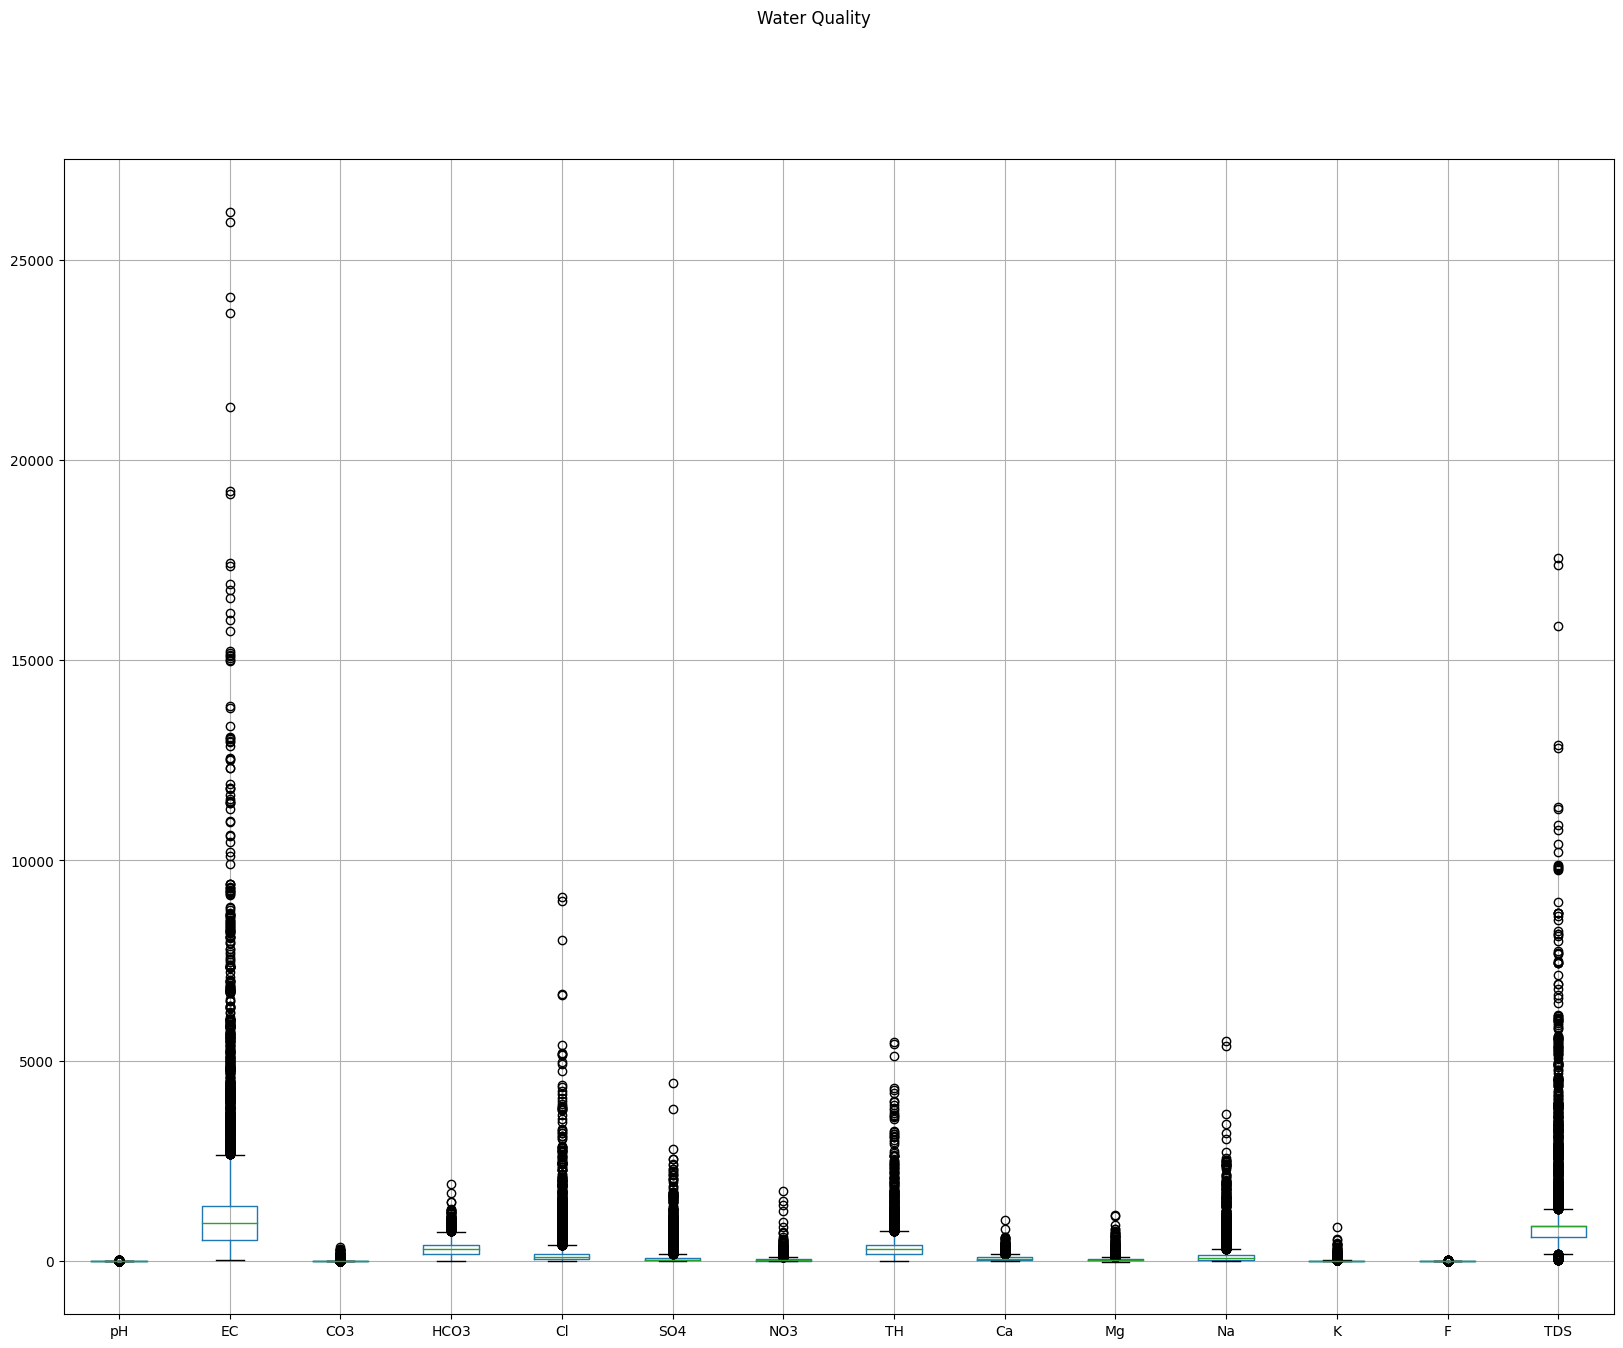

In [19]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# Z-score For outlier Handling




Number of outliers using Z-Score method- 729


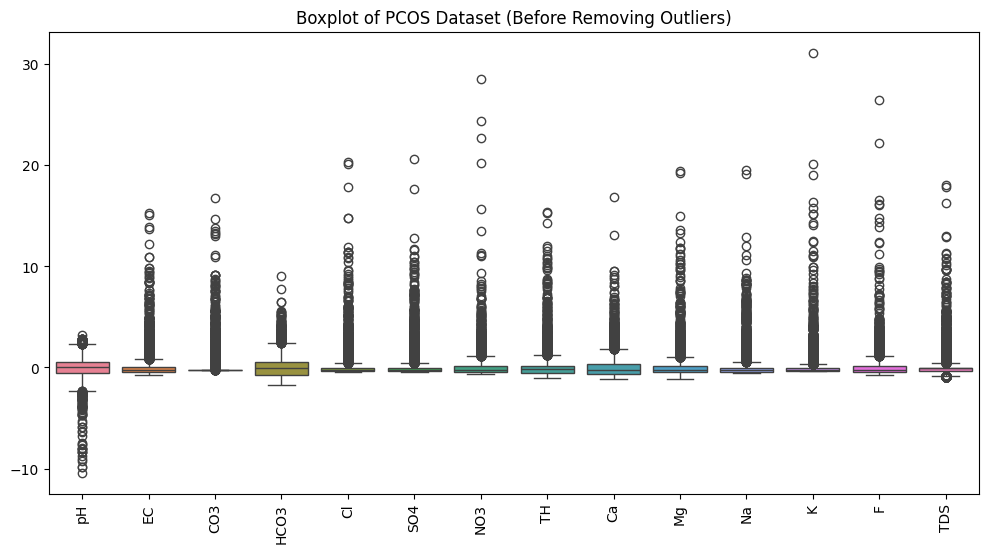

(8280, 14)

In [20]:
#remove outliner by z-score
from scipy import stats
# Here, almost all kde plots are Gaussian Like
# Using Z-Score Normalization to detect outliers
df_num_final = Required_parameters
df_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 5]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
Required_parameters.iloc[indices_arr, :]


#Remove outliners using z-score
# Calculate Z-scores for each column
z_scores = stats.zscore(df_final_norm)

threshold = 3

# Identify and remove rows with Z-scores above the threshold
indices_arr = (abs(z_scores) > threshold).any(axis=1)
df_no_outliers = df_final_norm[~indices_arr]

# Print the resulting DataFrame without outliers
# print(df_no_outliers)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(df_final_norm)
plt.title("Boxplot of PCOS Dataset (Before Removing Outliers)")
plt.xticks(rotation=90)
plt.show()

df_final_norm.shape

# Data Normalization

In [21]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(df_final_norm), columns=df_final_norm.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.756058,0.012297,0.000000,0.095561,0.002557,0.000226,0.000571,0.030947,0.031812,0.038827,0.001822,0.000000,0.037668,0.010862
1,0.722132,0.024180,0.000000,0.136815,0.008839,0.001129,0.000571,0.044714,0.049595,0.044866,0.009291,0.001186,0.012556,0.020840
2,0.717286,0.009279,0.000000,0.060574,0.003659,0.000226,0.000000,0.021770,0.002173,0.044003,0.001822,0.001186,0.020628,0.007726
3,0.733441,0.010846,0.000000,0.083029,0.004100,0.000451,0.000000,0.023605,0.023908,0.034513,0.002733,0.002372,0.016592,0.010406
4,0.768982,0.094520,0.000000,0.267363,0.061522,0.012641,0.002857,0.084178,0.053547,0.088007,0.061213,0.021352,0.042601,0.080310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.728723,0.079003,0.000000,0.120752,0.058498,0.022941,0.035708,0.156605,0.191475,0.097406,0.015401,0.000813,0.013818,0.079143
8276,0.824090,0.087811,0.000000,0.246089,0.053468,0.021550,0.023643,0.128581,0.035810,0.147910,0.040262,0.032102,0.044493,0.048729
8277,0.770505,0.098363,0.000000,0.131781,0.057481,0.063966,0.084451,0.149130,0.087877,0.144135,0.042314,0.001414,0.028172,0.098345
8278,0.911042,0.049198,0.107728,0.212639,0.012304,0.028798,0.029221,0.060953,0.014432,0.082301,0.027572,0.064934,0.041020,0.048487


#Main data


In [22]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [23]:
from deap import creator, base, tools, algorithms

In [24]:
import deap
from deap import creator

Data Spliting

In [25]:
# Splitting the dataset into features (X) and target (y)
X = normalized_data
y = resampled_data['Potability']

In [26]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Implementation

# Logistic Regression with Genetic

In [27]:
# Assuming X_train and y_train are your training features and labels

# Define the evaluation function for genetic algorithm
def eval_fitness(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,


#fixed_selected_features = [3,4,6,7,10,11,13,14]


# Initialize genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X_train.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Set the model and other parameters
genetic_lr_model = LogisticRegression()
toolbox.register("evaluate", eval_fitness, X=X_train, y=y_train, model=genetic_lr_model)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population_size = 100
num_generations = 10
pop = toolbox.population(n=population_size)

# Run the genetic algorithm
for gen in range(num_generations):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.8, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fits):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))

# Extract selected features from the best individual
best_individual = tools.selBest(pop, k=1)[0]
genetic_selected_features_lr = [i for i in range(len(best_individual)) if best_individual[i]]

# Train a model on selected features
genetic_lr_model.fit(X_train.iloc[:, genetic_selected_features_lr], y_train)

# Making predictions on the training set
genetic_train_pred = genetic_lr_model.predict(X_train.iloc[:, genetic_selected_features_lr])

# Calculating the accuracy scores
genetic_accuracy_train = accuracy_score(y_train, genetic_train_pred)
print("\nTraining Accuracy Score (Genetic Algorithm):", genetic_accuracy_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Training Accuracy Score (Genetic Algorithm): 0.7957427536231884


In [28]:
# Assuming genetic_selected_features is the list of features selected by the genetic algorithm

# Create a DataFrame for genetic feature ranking
genetic_feature_ranking_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_lr else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_lr = genetic_feature_ranking_df.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_lr.head(len(genetic_selected_features_lr)))

   Feature  Selected
1       EC         1
2      CO3         1
4       Cl         1
5      SO4         1
6      NO3         1
7       TH         1
8       Ca         1
9       Mg         1
10      Na         1
11       K         1
12       F         1
13     TDS         1


In [29]:
# Select the same features for the testing set
genetic_features_lr_arr_test = X_test.iloc[:, [1,2,4,5,6,7,8,9,10,11,12,13]].values

In [30]:
# Assuming genetic_lr_model is the Logistic Regression model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_lr = genetic_lr_model.predict(X_test.iloc[:, genetic_selected_features_lr])

# Calculating the accuracy scores
genetic_accuracy_test_lr = accuracy_score(y_test, genetic_test_pred_lr)
print("Testing Accuracy Score (Genetic Algorithm):", genetic_accuracy_test_lr)

Testing Accuracy Score (Genetic Algorithm): 0.7952898550724637


In [31]:
from sklearn.model_selection import cross_val_score

# Assuming genetic_lr_model is the Logistic Regression model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_lr = cross_val_score(genetic_lr_model, genetic_features_lr_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm):", np.mean(genetic_cv_scores_lr))


Mean CV Score on testing data (Genetic Algorithm): 0.7566447608616284


In [32]:
genetic_selected_features_lr

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
from sklearn.metrics import f1_score
print("\nTraining Accuracy Score:", genetic_accuracy_train)
print("Testing Accuracy Score:", genetic_accuracy_test_lr)
print("Mean CV Score on testing data:", np.mean(genetic_cv_scores_lr))
# Precision score on test data
precision_lr = precision_score(y_test, genetic_test_pred_lr, average='weighted')
print('Precision:', precision_lr)

# Recall score on test data
recall_lr = recall_score(y_test, genetic_test_pred_lr, average='weighted')
print('Recall:', recall_lr)

# F1-score on test data
f1_lr = f1_score(y_test, genetic_test_pred_lr, average='weighted')
print('F1-score:', f1_lr)

# Predict probabilities for ROC AUC
y_probabilities_lr = genetic_lr_model.predict_proba(X_test.iloc[:, genetic_selected_features_lr])
# y_probabilities_lr = genetic_lr_model.predict_proba(X_test[genetic_selected_features_lr])

# ROC area under the curve score
roc_auc_lr = roc_auc_score(y_test, y_probabilities_lr, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_lr)


Training Accuracy Score: 0.7957427536231884
Testing Accuracy Score: 0.7952898550724637
Mean CV Score on testing data: 0.7566447608616284
Precision: 0.8170955501635293
Recall: 0.7952898550724637
F1-score: 0.7898158096051299
ROC area: 0.9454360723647826


# Random Forest with Genetic

In [35]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [36]:
from deap import creator, base, tools

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Define the evaluation function for genetic algorithm with Random Forest
def eval_fitness_rf(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for Random Forest
genetic_rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
toolbox_rf = base.Toolbox()
toolbox_rf.register("attr_bool", np.random.choice, [0, 1], )  # 0: Feature not selected, 1: Feature selected
toolbox_rf.register("individual", tools.initRepeat, creator.Individual, toolbox_rf.attr_bool, n=len(X_train.columns))
toolbox_rf.register("population", tools.initRepeat, list, toolbox_rf.individual)
toolbox_rf.register("evaluate", eval_fitness_rf, X=X_train, y=y_train, model=genetic_rf_model)
toolbox_rf.register("mate", tools.cxTwoPoint)
toolbox_rf.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_rf.register("select", tools.selTournament, tournsize=3)

# Initialize population for Random Forest
pop_rf = toolbox_rf.population(n=population_size)

# Run the genetic algorithm for Random Forest
for gen in range(num_generations):
    offspring_rf = algorithms.varAnd(pop_rf, toolbox_rf, cxpb=0.8, mutpb=0.2)
    fits_rf = toolbox_rf.map(toolbox_rf.evaluate, offspring_rf)
    for ind_rf, fit_rf in zip(offspring_rf, fits_rf):
        ind_rf.fitness.values = fit_rf
    pop_rf = toolbox_rf.select(offspring_rf, k=len(pop_rf))

# Extract selected features from the best individual for Random Forest
best_individual_rf = tools.selBest(pop_rf, k=1)[0]
genetic_selected_features_rf = [i for i in range(len(best_individual_rf)) if best_individual_rf[i]]

# Train a Random Forest model on selected features
genetic_rf_model.fit(X_train.iloc[:, genetic_selected_features_rf], y_train)

# Making predictions on the training set for Random Forest
genetic_train_pred_rf = genetic_rf_model.predict(X_train.iloc[:, genetic_selected_features_rf])

# Calculating the accuracy scores for Random Forest
genetic_accuracy_train_rf = accuracy_score(y_train, genetic_train_pred_rf)
print("\nTraining Accuracy Score (Genetic Algorithm - Random Forest):", genetic_accuracy_train_rf)


Training Accuracy Score (Genetic Algorithm - Random Forest): 1.0


In [38]:
# Assuming genetic_selected_features_rf is the list of features selected by the genetic algorithm with Random Forest

# Create a DataFrame for genetic feature ranking with Random Forest
genetic_feature_ranking_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_rf else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_rf = genetic_feature_ranking_df_rf.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_rf.head(len(genetic_selected_features_rf)))


   Feature  Selected
1       EC         1
3     HCO3         1
4       Cl         1
5      SO4         1
6      NO3         1
7       TH         1
9       Mg         1
13     TDS         1


In [39]:
# Assuming genetic_selected_features_rf is the list of features selected by the genetic algorithm with Random Forest

# Select the same features for the testing set
genetic_features_rf_arr_test = X_test.iloc[:, [0,4,5,6,7,8,12]].values

In [40]:
# Assuming genetic_rf_model is the Random Forest model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_rf = genetic_rf_model.predict(X_test.iloc[:, genetic_selected_features_rf])

# Calculating the accuracy scores
genetic_accuracy_test_rf = accuracy_score(y_test, genetic_test_pred_rf)
print("Testing Accuracy Score (Genetic Algorithm - Random Forest):", genetic_accuracy_test_rf)

Testing Accuracy Score (Genetic Algorithm - Random Forest): 0.9402173913043478


In [41]:
# Assuming genetic_rf_model is the Random Forest model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_rf = cross_val_score(genetic_rf_model, genetic_features_rf_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm - Random Forest):", np.mean(genetic_cv_scores_rf))


Mean CV Score on testing data (Genetic Algorithm - Random Forest): 0.809748083242059


# SVM With Genetic

In [ ]:
from sklearn.svm import SVC

# Define the evaluation function for genetic algorithm with SVM
def eval_fitness_svm(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for SVM
genetic_svm_model = SVC(kernel='linear',probability=True)  # You can adjust the kernel and other parameters
toolbox_svm = base.Toolbox()
toolbox_svm.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected
toolbox_svm.register("individual", tools.initRepeat, creator.Individual, toolbox_svm.attr_bool, n=len(X_train.columns))
toolbox_svm.register("population", tools.initRepeat, list, toolbox_svm.individual)
toolbox_svm.register("evaluate", eval_fitness_svm, X=X_train, y=y_train, model=genetic_svm_model)
toolbox_svm.register("mate", tools.cxTwoPoint)
toolbox_svm.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_svm.register("select", tools.selTournament, tournsize=3)

# Initialize population for SVM
pop_svm = toolbox_svm.population(n=population_size)

# Run the genetic algorithm for SVM
for gen in range(num_generations):
    offspring_svm = algorithms.varAnd(pop_svm, toolbox_svm, cxpb=0.8, mutpb=0.2)
    fits_svm = toolbox_svm.map(toolbox_svm.evaluate, offspring_svm)
    for ind_svm, fit_svm in zip(offspring_svm, fits_svm):
        ind_svm.fitness.values = fit_svm
    pop_svm = toolbox_svm.select(offspring_svm, k=len(pop_svm))

# Extract selected features from the best individual for SVM
best_individual_svm = tools.selBest(pop_svm, k=1)[0]
genetic_selected_features_svm = [i for i in range(len(best_individual_svm)) if best_individual_svm[i]]

# Train an SVM model on selected features
genetic_svm_model.fit(X_train.iloc[:, genetic_selected_features_svm], y_train)

# Making predictions on the training set for SVM
genetic_train_pred_svm = genetic_svm_model.predict(X_train.iloc[:, genetic_selected_features_svm])

# Calculating the accuracy scores for SVM
genetic_accuracy_train_svm = accuracy_score(y_train, genetic_train_pred_svm)
print("\nTraining Accuracy Score (Genetic Algorithm - SVM):", genetic_accuracy_train_svm)



Training Accuracy Score (Genetic Algorithm - SVM): 0.8633756038647343


In [ ]:
# Assuming genetic_selected_features_svm is the list of features selected by the genetic algorithm with SVM

# Create a DataFrame for genetic feature ranking with SVM
genetic_feature_ranking_df_svm = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_svm else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_svm = genetic_feature_ranking_df_svm.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_svm.head(len(genetic_selected_features_svm)))

In [ ]:
# Assuming genetic_selected_features_svm is the list of features selected by the genetic algorithm with SVM

# Select the same features for the testing set
genetic_features_svm_arr_test = X_test.iloc[:, [0,1,3,4,5,6,7,8,9,10,11,12,13]].values


In [ ]:
# Assuming genetic_svm_model is the SVM model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_svm = genetic_svm_model.predict(X_test.iloc[:, genetic_selected_features_svm])

# Calculating the accuracy scores
genetic_accuracy_test_svm = accuracy_score(y_test, genetic_test_pred_svm)
print("Testing Accuracy Score (Genetic Algorithm - SVM):", genetic_accuracy_test_svm)


In [ ]:
# Assuming genetic_svm_model is the SVM model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_svm = cross_val_score(genetic_svm_model, genetic_features_svm_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm - SVM):", np.mean(genetic_cv_scores_svm))


# Decision Tree with Genetic

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the evaluation function for genetic algorithm with Decision Tree
def eval_fitness_dt(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for Decision Tree
genetic_dt_model = DecisionTreeClassifier(random_state=42)  # You can adjust other parameters
toolbox_dt = base.Toolbox()
toolbox_dt.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected
toolbox_dt.register("individual", tools.initRepeat, creator.Individual, toolbox_dt.attr_bool, n=len(X_train.columns))
toolbox_dt.register("population", tools.initRepeat, list, toolbox_dt.individual)
toolbox_dt.register("evaluate", eval_fitness_dt, X=X_train, y=y_train, model=genetic_dt_model)
toolbox_dt.register("mate", tools.cxTwoPoint)
toolbox_dt.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_dt.register("select", tools.selTournament, tournsize=3)

# Initialize population for Decision Tree
pop_dt = toolbox_dt.population(n=population_size)

# Run the genetic algorithm for Decision Tree
for gen in range(num_generations):
    offspring_dt = algorithms.varAnd(pop_dt, toolbox_dt, cxpb=0.8, mutpb=0.2)
    fits_dt = toolbox_dt.map(toolbox_dt.evaluate, offspring_dt)
    for ind_dt, fit_dt in zip(offspring_dt, fits_dt):
        ind_dt.fitness.values = fit_dt
    pop_dt = toolbox_dt.select(offspring_dt, k=len(pop_dt))

# Extract selected features from the best individual for Decision Tree
best_individual_dt = tools.selBest(pop_dt, k=1)[0]
genetic_selected_features_dt = [i for i in range(len(best_individual_dt)) if best_individual_dt[i]]

# Train a Decision Tree model on selected features
genetic_dt_model.fit(X_train.iloc[:, genetic_selected_features_dt], y_train)

# Making predictions on the training set for Decision Tree
genetic_train_pred_dt = genetic_dt_model.predict(X_train.iloc[:, genetic_selected_features_dt])

# Calculating the accuracy scores for Decision Tree
genetic_accuracy_train_dt = accuracy_score(y_train, genetic_train_pred_dt)
print("\nTraining Accuracy Score (Genetic Algorithm - Decision Tree):", genetic_accuracy_train_dt)



Training Accuracy Score (Genetic Algorithm - Decision Tree): 1.0


In [ ]:
# Assuming genetic_selected_features_dt is the list of features selected by the genetic algorithm with Decision Tree

# Create a DataFrame for genetic feature ranking with Decision Tree
genetic_feature_ranking_df_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_dt else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_dt = genetic_feature_ranking_df_dt.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_dt.head(len(genetic_selected_features_dt)))


   Feature  Selected
0       pH         1
2      CO3         1
3     HCO3         1
7       TH         1
8       Ca         1
9       Mg         1
11       K         1
12       F         1


In [ ]:
# Assuming genetic_selected_features_dt is the list of features selected by the genetic algorithm with Decision Tree

# Select the same features for the testing set
genetic_features_dt_arr_test = X_test.iloc[:, [0, 1, 2, 3, 4, 6, 8, 10, 11, 13]].values


In [ ]:
# Assuming genetic_dt_model is the Decision Tree model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_dt = genetic_dt_model.predict(X_test.iloc[:, genetic_selected_features_dt])

# Calculating the accuracy scores
genetic_accuracy_test_dt = accuracy_score(y_test, genetic_test_pred_dt)
print("Testing Accuracy Score (Genetic Algorithm - Decision Tree):", genetic_accuracy_test_dt)


Testing Accuracy Score (Genetic Algorithm - Decision Tree): 0.7705314009661836


In [ ]:
# Assuming genetic_dt_model is the Decision Tree model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_dt = cross_val_score(genetic_dt_model, genetic_features_dt_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm - Decision Tree):", np.mean(genetic_cv_scores_dt))


Mean CV Score on testing data (Genetic Algorithm - Decision Tree): 0.8128368017524645


# XGB with

In [ ]:
from deap import base

In [ ]:
from xgboost import XGBClassifier
from deap import creator, base, tools
from deap import creator
# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train = label_encoder.fit_transform(y_train)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test = label_encoder.fit_transform(y_test)

# Define the evaluation function for genetic algorithm with XGBoost
def eval_fitness_xgb(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for XGBoost
genetic_xgb_model = XGBClassifier(random_state=42)  # You can adjust other parameters
toolbox_xgb = base.Toolbox()
toolbox_xgb.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected-
# Define the Individual class
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox_xgb.register("individual", tools.initRepeat, creator.Individual, toolbox_xgb.attr_bool, n=len(X_train.columns))
toolbox_xgb.register("population", tools.initRepeat, list, toolbox_xgb.individual)
toolbox_xgb.register("evaluate", eval_fitness_xgb, X=X_train, y=y_train, model=genetic_xgb_model)
toolbox_xgb.register("mate", tools.cxTwoPoint)
toolbox_xgb.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_xgb.register("select", tools.selTournament, tournsize=3)

# Initialize population for XGBoost
pop_xgb = toolbox_xgb.population(n=population_size)

# Run the genetic algorithm for XGBoost
for gen in range(num_generations):
    offspring_xgb = algorithms.varAnd(pop_xgb, toolbox_xgb, cxpb=0.8, mutpb=0.2)
    fits_xgb = toolbox_xgb.map(toolbox_xgb.evaluate, offspring_xgb)
    for ind_xgb, fit_xgb in zip(offspring_xgb, fits_xgb):
        ind_xgb.fitness.values = fit_xgb
    pop_xgb = toolbox_xgb.select(offspring_xgb, k=len(pop_xgb))

# Extract selected features from the best individual for XGBoost
best_individual_xgb = tools.selBest(pop_xgb, k=1)[0]
genetic_selected_features_xgb = [i for i in range(len(best_individual_xgb)) if best_individual_xgb[i]]

# Train an XGBoost model on selected features
genetic_xgb_model.fit(X_train.iloc[:, genetic_selected_features_xgb], y_train)

# Making predictions on the training set for XGBoost
genetic_train_pred_xgb = genetic_xgb_model.predict(X_train.iloc[:, genetic_selected_features_xgb])

# Calculating the accuracy scores for XGBoost
genetic_accuracy_train_xgb = accuracy_score(y_train, genetic_train_pred_xgb)
print("\nTraining Accuracy Score (Genetic Algorithm - XGBoost):", genetic_accuracy_train_xgb)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
from xgboost import XGBClassifier
from deap import creator, base, tools
from deap import creator
# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train = label_encoder.fit_transform(y_train)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test = label_encoder.fit_transform(y_test)

# Define the evaluation function for genetic algorithm with XGBoost
def eval_fitness_xgb(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for XGBoost
genetic_xgb_model = XGBClassifier(random_state=42)  # You can adjust other parameters
toolbox_xgb = base.Toolbox()
toolbox_xgb.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected

from deap import creator

# Define the Individual class
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox_xgb.register("individual", tools.initRepeat, creator.Individual, toolbox_xgb.attr_bool, n=len(X_train.columns))
toolbox_xgb.register("population", tools.initRepeat, list, toolbox_xgb.individual)
toolbox_xgb.register("evaluate", eval_fitness_xgb, X=X_train, y=y_train, model=genetic_xgb_model)
toolbox_xgb.register("mate", tools.cxTwoPoint)
toolbox_xgb.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_xgb.register("select", tools.selTournament, tournsize=3)

# Initialize population for XGBoost
pop_xgb = toolbox_xgb.population(n=population_size)

# Run the genetic algorithm for XGBoost
for gen in range(num_generations):
    offspring_xgb = algorithms.varAnd(pop_xgb, toolbox_xgb, cxpb=0.8, mutpb=0.2)
    fits_xgb = toolbox_xgb.map(toolbox_xgb.evaluate, offspring_xgb)
    for ind_xgb, fit_xgb in zip(offspring_xgb, fits_xgb):
        ind_xgb.fitness.values = fit_xgb
    pop_xgb = toolbox_xgb.select(offspring_xgb, k=len(pop_xgb))

# Extract selected features from the best individual for XGBoost
best_individual_xgb = tools.selBest(pop_xgb, k=1)[0]
genetic_selected_features_xgb = [i for i in range(len(best_individual_xgb)) if best_individual_xgb[i]]

# Train an XGBoost model on selected features
genetic_xgb_model.fit(X_train.iloc[:, genetic_selected_features_xgb], y_train)

# Making predictions on the training set for XGBoost
genetic_train_pred_xgb = genetic_xgb_model.predict(X_train.iloc[:, genetic_selected_features_xgb])

# Calculating the accuracy scores for XGBoost
genetic_accuracy_train_xgb = accuracy_score(y_train, genetic_train_pred_xgb)
print("\nTraining Accuracy Score (Genetic Algorithm - XGBoost):", genetic_accuracy_train_xgb)


In [ ]:
# Assuming genetic_selected_features_xgb is the list of features selected by the genetic algorithm with XGBoost

# Create a DataFrame for genetic feature ranking with XGBoost
genetic_feature_ranking_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_xgb else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_xgb = genetic_feature_ranking_df_xgb.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_xgb.head(len(genetic_selected_features_xgb)))

   Feature  Selected
0       pH         1
1       EC         1
3     HCO3         1
4       Cl         1
8       Ca         1
9       Mg         1
10      Na         1
13     TDS         1


In [ ]:
# Assuming genetic_selected_features_xgb is the list of features selected by the genetic algorithm with XGBoost

# Select the same features for the testing set
genetic_features_xgb_arr_test = X_test.iloc[:, [0, 1, 3, 4, 8, 9, 10, 13]].values

In [ ]:
# Assuming genetic_xgb_model is the XGBoost model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_xgb = genetic_xgb_model.predict(X_test.iloc[:, genetic_selected_features_xgb])

# Calculating the accuracy scores
genetic_accuracy_test_xgb = accuracy_score(y_test, genetic_test_pred_xgb)
print("Testing Accuracy Score (Genetic Algorithm - XGBoost):", genetic_accuracy_test_xgb)

Testing Accuracy Score (Genetic Algorithm - XGBoost): 0.9371980676328503


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming genetic_xgb_model is the XGBoost model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_xgb = cross_val_score(genetic_xgb_model, genetic_features_xgb_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm - XGBoost):", np.mean(genetic_cv_scores_xgb))


Mean CV Score on testing data (Genetic Algorithm - XGBoost): 0.9027893391748814


# KNN with Genetic

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the evaluation function for genetic algorithm with KNN
def eval_fitness_knn(individual, X, y, model):
    selected_features = [i for i in range(len(individual)) if individual[i]]
    if len(selected_features) == 0:
        return 0.0,  # Avoid selecting no features
    model.fit(X.iloc[:, selected_features], y)
    predictions = model.predict(X.iloc[:, selected_features])
    accuracy = accuracy_score(y, predictions)
    return accuracy,

# Initialize genetic algorithm parameters for KNN
genetic_knn_model = KNeighborsClassifier()  # You can adjust other parameters
toolbox_knn = base.Toolbox()
toolbox_knn.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected
toolbox_knn.register("individual", tools.initRepeat, creator.Individual, toolbox_knn.attr_bool, n=len(X_train.columns))
toolbox_knn.register("population", tools.initRepeat, list, toolbox_knn.individual)
toolbox_knn.register("evaluate", eval_fitness_knn, X=X_train, y=y_train, model=genetic_knn_model)
toolbox_knn.register("mate", tools.cxTwoPoint)
toolbox_knn.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_knn.register("select", tools.selTournament, tournsize=3)

# Initialize population for KNN
pop_knn = toolbox_knn.population(n=population_size)

# Run the genetic algorithm for KNN
for gen in range(num_generations):
    offspring_knn = algorithms.varAnd(pop_knn, toolbox_knn, cxpb=0.8, mutpb=0.2)
    fits_knn = toolbox_knn.map(toolbox_knn.evaluate, offspring_knn)
    for ind_knn, fit_knn in zip(offspring_knn, fits_knn):
        ind_knn.fitness.values = fit_knn
    pop_knn = toolbox_knn.select(offspring_knn, k=len(pop_knn))

# Extract selected features from the best individual for KNN
best_individual_knn = tools.selBest(pop_knn, k=1)[0]
genetic_selected_features_knn = [i for i in range(len(best_individual_knn)) if best_individual_knn[i]]

# Train a KNN model on selected features
genetic_knn_model.fit(X_train.iloc[:, genetic_selected_features_knn], y_train)

# Making predictions on the training set for KNN
genetic_train_pred_knn = genetic_knn_model.predict(X_train.iloc[:, genetic_selected_features_knn])

# Calculating the accuracy scores for KNN
genetic_accuracy_train_knn = accuracy_score(y_train, genetic_train_pred_knn)
print("\nTraining Accuracy Score (Genetic Algorithm - KNN):", genetic_accuracy_train_knn)

In [ ]:
# Assuming genetic_selected_features_knn is the list of features selected by the genetic algorithm with KNN

# Create a DataFrame for genetic feature ranking with KNN
genetic_feature_ranking_df_knn = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': [1 if i in genetic_selected_features_knn else 0 for i in range(len(X_train.columns))]
})

# Sort the DataFrame based on the selected features
genetic_feature_ranking_df_knn = genetic_feature_ranking_df_knn.sort_values(by='Selected', ascending=False)

# Display the DataFrame
print(genetic_feature_ranking_df_knn.head(len(genetic_selected_features_knn)))

   Feature  Selected
1       EC         1
6      NO3         1
7       TH         1
9       Mg         1
10      Na         1
11       K         1
12       F         1
13     TDS         1


In [ ]:
# Assuming genetic_selected_features_knn is the list of features selected by the genetic algorithm with KNN

# Select the same features for the testing set
genetic_features_knn_arr_test = X_test.iloc[:, [1, 6, 7, 9, 10, 11, 12, 13]].values


In [ ]:
# Assuming genetic_knn_model is the KNN model trained with genetic algorithm selected features

# Making predictions on the testing set with features selected by the genetic algorithm
genetic_test_pred_knn = genetic_knn_model.predict(X_test.iloc[:, genetic_selected_features_knn])

# Calculating the accuracy scores for testing set
genetic_accuracy_test_knn = accuracy_score(y_test, genetic_test_pred_knn)
print("Testing Accuracy Score (Genetic Algorithm - KNN):", genetic_accuracy_test_knn)

Testing Accuracy Score (Genetic Algorithm - KNN): 0.908816425120773


In [ ]:
# Assuming genetic_knn_model is the KNN model trained with genetic algorithm selected features

# Perform cross-validation on the testing dataset
genetic_cv_scores_knn = cross_val_score(genetic_knn_model, genetic_features_knn_arr_test, y_test, cv=10, scoring='accuracy')
print("\nMean CV Score on testing data (Genetic Algorithm - KNN):", np.mean(genetic_cv_scores_knn))


Mean CV Score on testing data (Genetic Algorithm - KNN): 0.8773749543629062


# Gradient Boost Classifier with Genetic

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Define the evaluation function for genetic algorithm with Gradient Boosting
# def eval_fitness_gb(individual, X, y, model):
#     selected_features = [i for i in range(len(individual)) if individual[i]]
#     if len(selected_features) == 0:
#         return 0.0,  # Avoid selecting no features
#     model.fit(X.iloc[:, selected_features], y)
#     predictions = model.predict(X.iloc[:, selected_features])
#     accuracy = accuracy_score(y, predictions)
#     return accuracy,

# # Initialize genetic algorithm parameters for Gradient Boosting
# genetic_gb_model = GradientBoostingClassifier(random_state=42)  # You can adjust other parameters
# toolbox_gb = base.Toolbox()
# toolbox_gb.register("attr_bool", np.random.choice, [0, 1])  # 0: Feature not selected, 1: Feature selected
# toolbox_gb.register("individual", tools.initRepeat, creator.Individual, toolbox_gb.attr_bool, n=len(X_train.columns))
# toolbox_gb.register("population", tools.initRepeat, list, toolbox_gb.individual)
# toolbox_gb.register("evaluate", eval_fitness_gb, X=X_train, y=y_train, model=genetic_gb_model)
# toolbox_gb.register("mate", tools.cxTwoPoint)
# toolbox_gb.register("mutate", tools.mutFlipBit, indpb=0.05)
# toolbox_gb.register("select", tools.selTournament, tournsize=3)

# # Initialize population for Gradient Boosting
# pop_gb = toolbox_gb.population(n=population_size)

# # Run the genetic algorithm for Gradient Boosting
# for gen in range(num_generations):
#     offspring_gb = algorithms.varAnd(pop_gb, toolbox_gb, cxpb=0.8, mutpb=0.2)
#     fits_gb = toolbox_gb.map(toolbox_gb.evaluate, offspring_gb)
#     for ind_gb, fit_gb in zip(offspring_gb, fits_gb):
#         ind_gb.fitness.values = fit_gb
#     pop_gb = toolbox_gb.select(offspring_gb, k=len(pop_gb))

# # Extract selected features from the best individual for Gradient Boosting
# best_individual_gb = tools.selBest(pop_gb, k=1)[0]
# genetic_selected_features_gb = [i for i in range(len(best_individual_gb)) if best_individual_gb[i]]

# # Train a Gradient Boosting model on selected features
# genetic_gb_model.fit(X_train.iloc[:, genetic_selected_features_gb], y_train)

# # Making predictions on the training set for Gradient Boosting
# genetic_train_pred_gb = genetic_gb_model.predict(X_train.iloc[:, genetic_selected_features_gb])

# # Calculating the accuracy scores for Gradient Boosting
# genetic_accuracy_train_gb = accuracy_score(y_train, genetic_train_pred_gb)
# print("\nTraining Accuracy Score (Genetic Algorithm - Gradient Boosting):", genetic_accuracy_train_gb)

In [ ]:
# # Create a DataFrame for genetic feature ranking with Gradient Boosting
# genetic_feature_ranking_df_gb = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Selected': [1 if i in genetic_selected_features_gb else 0 for i in range(len(X_train.columns))]
# })

# # Sort the DataFrame based on the selected features
# genetic_feature_ranking_df_gb = genetic_feature_ranking_df_gb.sort_values(by='Selected', ascending=False)

# # Display the DataFrame
# print(genetic_feature_ranking_df_gb.head(len(genetic_selected_features_gb)))

In [ ]:
# # Select the same features for the testing set
# genetic_features_gb_arr_test = X_test.iloc[:, genetic_selected_features_gb].values

In [ ]:
# # Making predictions on the testing set with features selected by the genetic algorithm
# genetic_test_pred_gb = genetic_gb_model.predict(genetic_features_gb_arr_test)

# # Calculating the accuracy scores
# genetic_accuracy_test_gb = accuracy_score(y_test, genetic_test_pred_gb)
# print("Testing Accuracy Score (Genetic Algorithm - Gradient Boosting):", genetic_accuracy_test_gb)

In [ ]:
# # Perform cross-validation on the testing dataset
# genetic_cv_scores_gb = cross_val_score(genetic_gb_model, genetic_features_gb_arr_test, y_test, cv=10, scoring='accuracy')
# print("\nMean CV Score on testing data (Genetic Algorithm - Gradient Boosting):", np.mean(genetic_cv_scores_gb))

# MLP with Genetic

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # Create an MLP model
# mlp_model = MLPClassifier(hidden_layer_sizes=(3,2), max_iter=500, activation='relu')

# # Train the MLP model on the training data
# mlp_model.fit(X_train_main,y_train_main)

# # Predict labels on the training and testing data
# mlp_train_pred = mlp_model.predict(X_train_main)
# mlp_test_pred = mlp_model.predict(X_test_main)

# # Calculate training and testing accuracy
# mlp_train_accuracy = accuracy_score(y_train_main, mlp_train_pred)
# mlp_test_accuracy = accuracy_score(y_test_main, mlp_test_pred)

# # Calculating the accuracy score
# mlp_accuracy = accuracy_score(y_test_main, mlp_test_pred)

# # Perform cross-validation
# cv_scores = cross_val_score(mlp_model, X_train_main, y_train_main, cv=5)

# # Print the results
# print("Training Accuracy:", mlp_train_accuracy)
# print("Testing Accuracy:", mlp_test_accuracy)
# #print("Cross-Validation Scores:", cv_scores)
# print("Mean Cross-Validation Score:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Training Accuracy: 0.9954710144927537
Testing Accuracy: 0.9915458937198067
Mean Cross-Validation Score: 0.9494323661859431


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('lr',genetic_lr_model),
    ('rf',genetic_rf_model),
    ('svm', genetic_svm_model),
    ('dt',genetic_dt_model),
    ('XGB',genetic_xgb_model),

    # ('GB',genetic_gb_model),
      ]

# Build stack model
genetic_stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator= LogisticRegression()
)

# Train stacked model
genetic_stack_model.fit(X, y)

# Make predictions
genetic_y_train_pred_stack = genetic_stack_model.predict(X)
genetic_y_test_pred_stack = genetic_stack_model.predict(X)

# Training set model performance
genetic_stack_model_train_accuracy = accuracy_score(y, genetic_y_train_pred_stack) # rfelculate Accuracy
#stack_model_train_f1 = f1_score(y_train_corr, rfe_y_train_pred, average='weighted') # rfelculate F1-score

# Test set model performance
genetic_stack_model_test_accuracy = accuracy_score(y, genetic_y_test_pred_stack) # rfelculate Accuracy
#stack_model_test_f1 = f1_score(y_test_corr, rfe_y_test_pred, average='weighted') # rfelculate F1-score

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
genetic_stack_cv_scores = cross_val_score(genetic_stack_model, genetic_features_lr_arr_test, y, cv=5, scoring='accuracy')
genetic_stack_cv_scores = np.mean(genetic_stack_cv_scores)

#Precision score on test data
genetic_precision_stack = precision_score(y, genetic_y_test_pred_stack, average='weighted')

from sklearn.metrics import recall_score
# Recall score on test data
genetic_Recall_stack = recall_score(y, genetic_y_test_pred_stack, average='weighted')

# F1-score on test data y_probabilities_lr
genetic_f1_stack = f1_score(y, genetic_y_test_pred_stack, average='weighted')

# Predict probabilities for ROC AUC
genetic_y_probabilities_stack = genetic_lr_model.predict_proba(X)

# ROC area under the curve score
genetic_roc_auc_stack = roc_auc_score(y, rfe_y_probabilities_stack, average='weighted', multi_class='ovr')

print('Traing Accuracy: %s' % genetic_stack_model_train_accuracy)
print('Testing Accuracy: %s' % genetic_stack_model_test_accuracy)
print("Mean CV Score on testing data:", genetic_stack_cv_scores)
print('Precision:', genetic_precision_stack)
print('Recall:', genetic_Recall_stack)
print('F1-score:', genegtic_f1_stack)
print('ROC area:', genetic_roc_auc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ValueError: Found input variables with inconsistent numbers of samples: [1656, 8280]

# Hyper Parameter Tunning

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Logistic

In [ ]:
X1 = X.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]].values
Y1 = y
# Splitting the dataset into the Training set and Test set
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [ ]:
X1_test_df = pd.DataFrame(X1_test)
genetic_lr_features_arr = X1_test_df.iloc[:,[0,1,2,6,7,8,9,11,12,13]].values

In [ ]:
# Specify parameters

c_values = list(np.arange(1, 10))

param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

# Now, perform GridSearchCV
grid_lr = GridSearchCV(genetic_lr_model, param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X1_train, Y1_train)

# Print best parameters and score
print(grid_lr.best_params_)
print(grid_lr.best_score_)

# Get the best estimator
best_genetic_lr_model = grid_lr.best_estimator_

# Make predictions
predictionforest = best_genetic_lr_model.predict(X1_test)

genetic_lr_model.fit(X1_train, Y1_train)
# Train accuracy
y_train_pred = grid_lr.best_estimator_.predict(X1_train)
ig_lr_training_data_accuracy_hy = accuracy_score(Y1_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_lr_model.predict_proba(X1_test)

ig_lr_test_data_accuracy_hy = accuracy_score(Y1_test,predictionforest)

# Precision score on test data
ig_lr_cv_scores_hy = cross_val_score(grid_lr, genetic_lr_features_arr, Y1_test, cv=5, scoring='accuracy')
ig_lr_cv_scores_hy = np.mean(ig_lr_cv_scores_hy)
# Precision score on test data
precision_lr_hy = precision_score(Y1_test, predictionforest, average='weighted')

# Recall score on test data
recall_lr_hy = recall_score(Y1_test, predictionforest, average='weighted')

# F1-score on test data
f1_lr_hy = f1_score(Y1_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_lr_hy = grid_lr.predict_proba(X1_test)

# ROC area under the curve score
roc_auc_lr_hy = roc_auc_score(Y1_test, y_probabilities_lr_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ig_lr_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ig_lr_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_lr_cv_scores_hy)
print('Precision:', precision_lr_hy)
print('Recall:', recall_lr_hy)
print('F1-score:', f1_lr_hy)
print('ROC area:', roc_auc_lr_hy)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 9, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
0.8180831100723935
Accuracy score of training data while using Logistic Regression: 0.8278985507246377
Accuracy score of testing data while using Logistic Regression: 0.8194444444444444
Mean CV Score on testing data: 0.7488006406289813
Precision: 0.8139534962997339
Recall: 0.8194444444444444
F1-score: 0.8154993156958706
ROC area: 0.9529383881368337


# Random Forest

In [ ]:
X2 = X.iloc[:,[0,1,2,5,7,10,12,13]].values
Y2 = y
# Splitting the dataset into the Training set and Test set
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [ ]:
X2_test_df = pd.DataFrame(X2_test)
genetic_rf_features_arr = X2_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Specify parameters for Random Forest
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_rf = {
    'n_estimators': n_estimators_values,
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}

# Now, perform GridSearchCV
grid_rf = GridSearchCV(genetic_rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X2_train, Y2_train)

# Print best parameters and score
print(grid_rf.best_params_)
print(grid_rf.best_score_)

# Get the best estimator
best_genetic_rf_model = grid_rf.best_estimator_

# Make predictions
predictionforest = best_genetic_rf_model.predict(X2_test)

genetic_rf_model.fit(X2_train, Y2_train)
# Train accuracy
y_train_pred = grid_rf.best_estimator_.predict(X2_train)
ig_rf_training_data_accuracy_hy = accuracy_score(Y2_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_rf_model.predict_proba(X2_test)

ig_rf_test_data_accuracy_hy = accuracy_score(Y2_test,predictionforest)

# Precision score on test data
ig_rf_cv_scores_hy = cross_val_score(grid_rf, genetic_rf_features_arr, Y2_test, cv=5, scoring='accuracy')
ig_rf_cv_scores_hy = np.mean(ig_rf_cv_scores_hy)
# Precision score on test data
precision_rf_hy = precision_score(Y2_test, predictionforest, average='weighted')

# Recall score on test data
recall_rf_hy = recall_score(Y2_test, predictionforest, average='weighted')

# F1-score on test data
f1_rf_hy = f1_score(Y2_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_rf_hy = grid_rf.predict_proba(X2_test)

# ROC area under the curve score
roc_auc_rf_hy = roc_auc_score(Y2_test, y_probabilities_rf_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Random Forest:', ig_rf_training_data_accuracy_hy)
print('Accuracy score of testing data while using Random Forest:', ig_rf_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_rf_cv_scores_hy)
print('Precision:', precision_rf_hy)
print('Recall:', recall_rf_hy)
print('F1-score:', f1_rf_hy)
print('ROC area:', roc_auc_rf_hy)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.9301028330388188
Accuracy score of training data while using Logistic Regression: 1.0
Accuracy score of testing data while using Logistic Regression: 0.9426328502415459
Mean CV Score on testing data: 0.9064117497179047
Precision: 0.9434024370751862
Recall: 0.9426328502415459
F1-score: 0.9425777981266544
ROC area: 0.9961292529108885


# SVM

In [ ]:
X3 = X.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12,13]].values
Y3 = y
# Splitting the dataset into the Training set and Test set
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=42)

In [ ]:
X3_test_df = pd.DataFrame(X3_test)
genetic_svm_features_arr = X3_test

In [ ]:
genetic_svm_model = SVC(kernel='linear',probability=True)  # You can adjust the kernel and other parameters

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Specify parameters for SVM
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'rbf', 'poly']
gamma_values = ['scale', 'auto']

param_grid_svm = {
    'C': C_values,
    'kernel': kernel_values,
    'gamma': gamma_values
}

# Now, perform GridSearchCV
grid_svm= GridSearchCV(genetic_svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X3_train, Y3_train)

# Print best parameters and score
print(grid_svm.best_params_)
print(grid_svm.best_score_)

# Get the best estimator
best_genetic_svm_model = grid_svm.best_estimator_

# Make predictions
predictionforest = best_genetic_svm_model.predict(X3_test)

genetic_svm_model.fit(X3_train, Y3_train)
# Train accuracy
y_train_pred = grid_svm.best_estimator_.predict(X3_train)
ig_svm_training_data_accuracy_hy = accuracy_score(Y3_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_svm_model.predict_proba(X3_test)

ig_svm_test_data_accuracy_hy = accuracy_score(Y3_test,predictionforest)

# Precision score on test data
ig_svm_cv_scores_hy = cross_val_score(grid_svm, genetic_svm_features_arr, Y3_test, cv=5, scoring='accuracy')
ig_svm_cv_scores_hy = np.mean(ig_svm_cv_scores_hy)
# Precision score on test data
precision_svm_hy = precision_score(Y3_test, predictionforest, average='weighted')

# Recall score on test data
recall_svm_hy = recall_score(Y3_test, predictionforest, average='weighted')

# F1-score on test data
f1_svm_hy = f1_score(Y3_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_svm_hy = grid_svm.predict_proba(X3_test)

# ROC area under the curve score
roc_auc_svm_hy = roc_auc_score(Y3_test, y_probabilities_svm_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using SVM:', ig_svm_training_data_accuracy_hy)
print('Accuracy score of testing data while using SVM:', ig_svm_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_svm_cv_scores_hy)
print('Precision:', precision_svm_hy)
print('Recall:', recall_svm_hy)
print('F1-score:', f1_svm_hy)
print('ROC area:', roc_auc_svm_hy)

{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.9595402154705581
Accuracy score of training data while using Logistic Regression: 0.9678442028985508
Accuracy score of testing data while using Logistic Regression: 0.9565217391304348
Mean CV Score on testing data: 0.9251264878244095
Precision: 0.9571608469048248
Recall: 0.9565217391304348
F1-score: 0.9563950427666309
ROC area: 0.9986100091439654


# Decision Tree

In [ ]:
X4 = X.iloc[:,[0, 1, 3, 4, 5, 6, 7, 10, 12]].values
Y4 = y
# Splitting the dataset into the Training set and Test set
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size=0.2, random_state=42)

In [ ]:
X4_test_df = pd.DataFrame(X4_test)
genetic_dt_features_arr = X4_test

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Specify parameters for Decision Tree
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_dt = {
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}

# Now, perform GridSearchCV
grid_dt = GridSearchCV(genetic_dt_model, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X4_train, Y4_train)

# Print best parameters and score
print(grid_dt.best_params_)
print(grid_dt.best_score_)

# Get the best estimator
best_genetic_dt_model = grid_dt.best_estimator_

# Make predictions
predictionforest = best_genetic_dt_model.predict(X4_test)

genetic_dt_model.fit(X4_train, Y4_train)
# Train accuracy
y_train_pred = grid_dt.best_estimator_.predict(X4_train)
ig_dt_training_data_accuracy_hy = accuracy_score(Y4_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_dt_model.predict_proba(X4_test)

ig_dt_test_data_accuracy_hy = accuracy_score(Y4_test,predictionforest)

# Precision score on test data
ig_dt_cv_scores_hy = cross_val_score(grid_dt, genetic_dt_features_arr, Y4_test, cv=5, scoring='accuracy')
ig_dt_cv_scores_hy = np.mean(ig_dt_cv_scores_hy)
# Precision score on test data
precision_dt_hy = precision_score(Y4_test, predictionforest, average='weighted')

# Recall score on test data
recall_dt_hy = recall_score(Y1_test, predictionforest, average='weighted')

# F1-score on test data
f1_dt_hy = f1_score(Y4_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_dt_hy = grid_dt.predict_proba(X4_test)

# ROC area under the curve score
roc_auc_dt_hy = roc_auc_score(Y4_test, y_probabilities_dt_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Decision Tree:', ig_dt_training_data_accuracy_hy)
print('Accuracy score of testing data while using Decision Tree:', ig_dt_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_dt_cv_scores_hy)
print('Precision:', precision_dt_hy)
print('Recall:', recall_dt_hy)
print('F1-score:', f1_dt_hy)
print('ROC area:', roc_auc_dt_hy)


{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
0.8866241805848487
Accuracy score of training data while using Logistic Regression: 0.9470108695652174
Accuracy score of testing data while using Logistic Regression: 0.8870772946859904
Mean CV Score on testing data: 0.8508754049430349
Precision: 0.8877042912029854
Recall: 0.8870772946859904
F1-score: 0.8871062727281859
ROC area: 0.9670403704103666


# XGB

In [ ]:
X5 = X.iloc[:,[0,1,2,4,6,7,9,10]].values
Y5 = y
# Splitting the dataset into the Training set and Test set
X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5, Y5, test_size=0.2, random_state=42)

In [ ]:
X5_test_df = pd.DataFrame(X5_test)
genetic_xgb_features_arr = X5_test

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Specify parameters for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [50, 100, 150]
}

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
Y5_train = label_encoder.fit_transform(Y5_train)

# Now, perform GridSearchCV
grid_xgb = GridSearchCV(genetic_xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X5_train, Y5_train)

# Print best parameters and score
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

# Get the best estimator
best_genetic_xgb_model = grid_xgb.best_estimator_

# Make predictions
predictionforest = best_genetic_xgb_model.predict(X5_test)

genetic_xgb_model.fit(X5_train, Y5_train)
# Train accuracy
y_train_pred = grid_xgb.best_estimator_.predict(X5_train)
ig_xgb_training_data_accuracy_hy = accuracy_score(Y5_train, y_train_pred)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
Y5_test = label_encoder.fit_transform(Y5_test)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_xgb_model.predict_proba(X5_test)

ig_xgb_test_data_accuracy_hy = accuracy_score(Y1_test,predictionforest)

# Precision score on test data
ig_xgb_cv_scores_hy = cross_val_score(grid_xgb, genetic_xgb_features_arr, Y5_test, cv=5, scoring='accuracy')
ig_xgb_cv_scores_hy = np.mean(ig_xgb_cv_scores_hy)
# Precision score on test data
precision_xgb_hy = precision_score(Y5_test, predictionforest, average='weighted')

# Recall score on test data
recall_xgb_hy = recall_score(Y5_test, predictionforest, average='weighted')

# F1-score on test data
f1_xgb_hy = f1_score(Y5_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_xgb_hy = grid_xgb.predict_proba(X5_test)

# ROC area under the curve score
roc_auc_xgb_hy = roc_auc_score(Y5_test, y_probabilities_xgb_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using XGBoost:', ig_xgb_training_data_accuracy_hy)
print('Accuracy score of testing data while using XGBoost:', ig_xgb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_xgb_cv_scores_hy)
print('Precision:', precision_xgb_hy)
print('Recall:', recall_xgb_hy)
print('F1-score:', f1_xgb_hy)
print('ROC area:', roc_auc_xgb_hy)

NameError: name 'genetic_xgb_model' is not defined

# KNN

In [ ]:
X6 = X.iloc[:,[0,1,2,4,6,7,9,10]].values
Y6 = y
# Splitting the dataset into the Training set and Test set
X6_train, X6_test, Y6_train, Y6_test = train_test_split(X6, Y6, test_size=0.2, random_state=42)

In [ ]:
X6_test_df = pd.DataFrame(X6_test)
genetic_knn_features_arr = X6_test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Specify parameters for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Now, perform GridSearchCV
grid_knn = GridSearchCV(genetic_knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X6_train, Y6_train)

# Print best parameters and score
print(grid_knn.best_params_)
print(grid_knn.best_score_)

# Get the best estimator
best_genetic_knn_model = grid_knn.best_estimator_

# Make predictions
predictionforest = best_genetic_knn_model.predict(X6_test)

genetic_knn_model.fit(X6_train, Y6_train)
# Train accuracy
y_train_pred = grid_knn.best_estimator_.predict(X6_train)
ig_knn_training_data_accuracy_hy = accuracy_score(Y6_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=genetic_knn_model.predict_proba(X6_test)

ig_knn_test_data_accuracy_hy = accuracy_score(Y6_test,predictionforest)

# Precision score on test data
ig_knn_cv_scores_hy = cross_val_score(grid_knn, genetic_knn_features_arr, Y6_test, cv=5, scoring='accuracy')
ig_knn_cv_scores_hy = np.mean(ig_knn_cv_scores_hy)
# Precision score on test data
precision_knn_hy = precision_score(Y6_test, predictionforest, average='weighted')

# Recall score on test data
recall_knn_hy = recall_score(Y6_test, predictionforest, average='weighted')

# F1-score on test data
f1_knn_hy = f1_score(Y6_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_knn_hy = grid_knn.predict_proba(X6_test)

# ROC area under the curve score
roc_auc_knn_hy = roc_auc_score(Y6_test, y_probabilities_knn_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using KNN:', ig_knn_training_data_accuracy_hy)
print('Accuracy score of testing data while using KNN:', ig_knn_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_knn_cv_scores_hy)
print('Precision:', precision_knn_hy)
print('Recall:', recall_knn_hy)
print('F1-score:', f1_knn_hy)
print('ROC area:', roc_auc_knn_hy)







# # Create KNN model
# knn_model = KNeighborsClassifier()

# # Perform Grid Search Cross-Validation
# grid_knn = GridSearchCV(knn_model, param_grid_knn, cv=10, scoring='accuracy')
# grid_knn.fit(X6_train, Y6_train)

# # Print best parameters and best score
# print("Best Parameters: ", grid_knn.best_params_)
# print("Best Accuracy Score: ", grid_knn.best_score_)

# # Make predictions using the best model
# prediction_knn = grid_knn.best_estimator_.predict(X6_test)

# # Print confusion matrix and classification report
# print("Confusion Matrix:\n", confusion_matrix(Y6_test, prediction_knn))
# print("Classification Report:\n", classification_report(Y6_test, prediction_knn, labels=[1, 0]))

# # Print accuracy score
# acc_knn = accuracy_score(Y6_test, prediction_knn)
# print("Accuracy: ", acc_knn)

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.9056460126546201
Accuracy score of training data while using KNN: 1.0
Accuracy score of testing data while using KNN: 0.9051932367149759
Mean CV Score on testing data: 0.8629417974010847
Precision: 0.907135141003798
Recall: 0.9051932367149759
F1-score: 0.9051510320414432
ROC area: 0.987092333433328


In [ ]:
# Cross-validation score
cv_score_knn = cross_val_score(grid_knn.best_estimator_, X6, Y6, cv=5, scoring='accuracy').mean()
print("Cross-Validation Score: ", cv_score_knn)